<a href="https://colab.research.google.com/github/ranggawijaya321/Viola-Jones/blob/main/viola_jones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

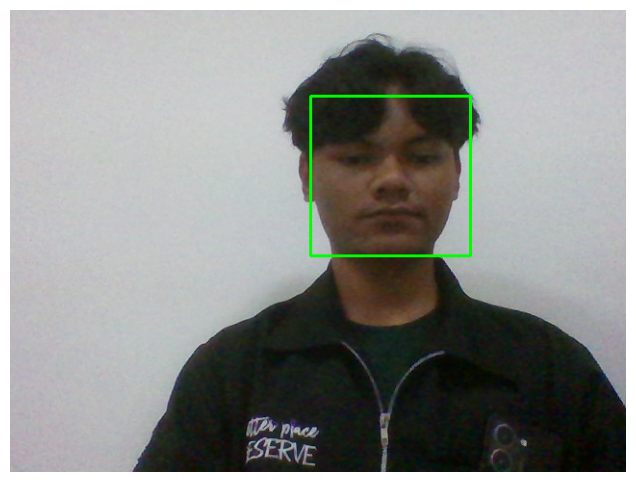

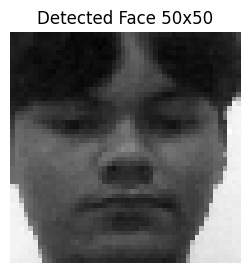

In [2]:
# ============================================================
# REALTIME WEBCAM - Viola–Jones + Detect & Save + Recognize + Delete Dataset
# Google Colab Compatible - 2025 (TOMBOL BERWARNA)
# ============================================================

!pip install -q opencv-python-headless

import cv2
import numpy as np
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
from google.colab import output
import os
import json

# ============================================================
# PERSIAPAN FOLDER & FILE
# ============================================================
if not os.path.exists("dataset"):
    os.mkdir("dataset")

label_file = "labels.json"

if not os.path.exists(label_file):
    with open(label_file, "w") as f:
        json.dump({}, f)

# ============================================================
# LOAD HAARCASCADE
# ============================================================
haarcascade = "haarcascade_frontalface_default.xml"
if not os.path.exists(haarcascade):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml

face_detector = cv2.CascadeClassifier(haarcascade)


# ============================================================
# HTML WEBCAM + TOMBOL BERWARNA
# ============================================================
html = """
<style>
#video {
    border: 3px solid black;
    margin-top: 10px;
}

/* ===== BUTTON STYLE ===== */
button {
    padding: 10px 15px;
    margin: 6px;
    font-size: 14px;
    font-weight: bold;
    border: none;
    border-radius: 6px;
    cursor: pointer;
    color: white;
}

/* Warna tombol */
#detectBtn  { background-color: #28a745; }       /* Hijau - Detect + Save */
#stopBtn    { background-color: #dc3545; }       /* Merah */
#deleteBtn  { background-color: #6c757d; }       /* Abu */
#recBtn     { background-color: #007bff; }       /* Biru */

button:hover {
    opacity: 0.85;
}

input {
    padding: 7px;
    font-size: 14px;
}
</style>

Nama orang / label:
<input id='labelbox' type='text' placeholder='Masukkan nama'><br><br>

<video id="video" autoplay playsinline width="480"></video><br>

<button id="detectBtn" onclick="detectAndSave()">🟢 Detect & Save</button>
<button id="stopBtn" onclick="stopCam()">⏹ Stop</button>
<button id="deleteBtn" onclick="deleteDataset()">🗑 Hapus Dataset</button>
<button id="recBtn" onclick="recognizeFace()">🔍 Recognize</button>

<script>
let stream;

async function startCam(){
    stream = await navigator.mediaDevices.getUserMedia({video: true});
    document.getElementById('video').srcObject = stream;
}

function stopCam(){
    if(stream){
        stream.getTracks().forEach(t => t.stop());
    }
}

function detectAndSave(){ sendFrame("detect_save"); }
function recognizeFace(){ sendFrame("recognize"); }

function deleteDataset(){
    google.colab.kernel.invokeFunction('delete_dataset', [], {});
}

function sendFrame(mode){
    const video = document.getElementById("video");
    const canvas = document.createElement("canvas");
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;

    const label = document.getElementById("labelbox").value;
    const ctx = canvas.getContext("2d");
    ctx.drawImage(video, 0, 0);

    google.colab.kernel.invokeFunction(
        'process_frame',
        [canvas.toDataURL("image/jpeg", 0.9), label, mode],
        {}
    );
}

startCam();
</script>
"""

display(HTML(html))


# ============================================================
# DELETE DATASET
# ============================================================
def delete_dataset():
    for f in os.listdir("dataset"):
        os.remove(f"dataset/{f}")

    with open(label_file, "w") as f:
        json.dump({}, f)

    clear_output(wait=True)
    print("🗑 Dataset berhasil dihapus!")

output.register_callback("delete_dataset", delete_dataset)


# ============================================================
# CALLBACK: DETECT & SAVE + RECOGNIZE
# ============================================================
def process_frame(data_url, label, mode):

    # Base64 → image
    header, encoded = data_url.split(",", 1)
    img_bytes = base64.b64decode(encoded)
    img_arr = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load label JSON
    with open(label_file, "r") as f:
        labels = json.load(f)

    label_list = list(labels.keys())

    # Deteksi wajah
    faces = face_detector.detectMultiScale(gray, 1.2, 5)

    if len(faces) == 0:
        clear_output(wait=True)
        display(HTML("<h3 style='color:red'>❌ Wajah tidak terdeteksi</h3>"))
        return

    # Proses tiap wajah
    for (x, y, w, h) in faces:
        face_crop = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face_crop, (50, 50))

        # ============================
        # MODE: DETECT + SAVE
        # ============================
        if mode == "detect_save":

            if label.strip() == "":
                label = "unknown"

            if label not in labels:
                labels[label] = 0

            filename = f"dataset/{label}_{labels[label]}.jpg"
            cv2.imwrite(filename, face_resized)

            labels[label] += 1

            with open(label_file, "w") as f:
                json.dump(labels, f, indent=4)

            status_html = f"<h3 style='color:green'>📁 Disimpan: {filename}</h3>"

        # ============================
        # MODE: RECOGNIZE
        # ============================
        elif mode == "recognize":

            X, y = [], []
            idx = 0

            for name in labels:
                for i in range(labels[name]):
                    path = f"dataset/{name}_{i}.jpg"
                    if os.path.exists(path):
                        img_data = cv2.imread(path, 0)
                        X.append(img_data)
                        y.append(idx)
                idx += 1

            if len(X) == 0:
                clear_output(wait=True)
                display(HTML("<h3 style='color:red'>⚠ Dataset kosong</h3>"))
                return

            recognizer = cv2.face.LBPHFaceRecognizer_create()
            recognizer.train(X, np.array(y))

            pred_label, confidence = recognizer.predict(face_resized)
            pred_name = label_list[pred_label]

            status_html = f"""
            <h3 style='color:blue'>
            🔍 Recognize:<br>
            Nama: <b>{pred_name}</b><br>
            Confidence: {confidence:.2f}
            </h3>
            """

        # Gambar kotak wajah
        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)

    # Tampilkan output
    clear_output(wait=True)
    display(HTML(status_html))

    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(3,3))
    plt.imshow(face_resized, cmap='gray')
    plt.title("Detected Face 50x50")
    plt.axis('off')
    plt.show()


# Register
output.register_callback("process_frame", process_frame)

print("🟢 Sistem siap! Klik 'Detect & Save' untuk menyimpan wajah.")


In [ ]:
import os

files = os.listdir("dataset")
files


['Rangga Wijaya_0.jpg', 'unknown_0.jpg']